<a href="https://colab.research.google.com/github/WerWin09/Bioinformatyka/blob/main/main_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Plik      Lev  %błędnych  len(oryg)   len(rek)
--------------------------------------------------
  200_01   144.00      72.00        200        191
  200_02   147.00      73.50        200        191
  200_03   145.00      72.50        200        191
  200_04   143.00      71.50        200        191
  200_05   147.00      73.50        200        191
  200_06   153.00      76.50        200        191
  200_07   147.00      73.50        200        191
  200_08   148.00      74.00        200        191
  200_09   153.00      76.50        200        191
  200_10   136.00      68.00        200        191
  200_11   131.00      65.50        200        191
  200_12   148.00      74.00        200        191
  200_13   141.00      70.50        200        191
  200_14   130.00      65.00        200        191
  200_15   139.00      69.50        200        191
  200_16   130.00      65.00        200        191
  200_17   141.00      70.50        200        191
  200_18   148.00      74.00   

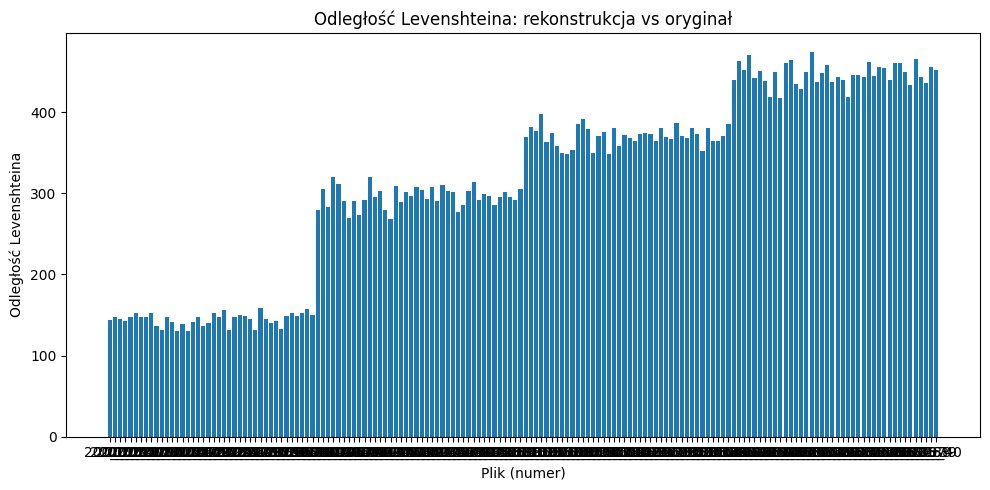

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Funkcja do obliczania odległości Levenshteina (porównanie rekonstrukcji do oryginału)
def levenshtein_distance(s1, s2):
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        for j in range(n+1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
    return dp[m][n]

# Funkcja czytająca plik z odczytami (reads)
# Format pliku: długość sekwencji, liczba odczytów, odczyty (każdy w osobnej linii)
def read_reads_file(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    seq_length = int(lines[0].strip())             # pierwsza linia: długość oryginalnej sekwencji
    n_reads = int(lines[1].strip())                # druga linia: liczba odczytów (reads)
    reads = [line.strip() for line in lines[2:] if set(line.strip()).issubset({'A','T','C','G'})]
    return seq_length, n_reads, reads

# Funkcja wczytująca sekwencję referencyjną (oryginał DNA) z pliku
def read_reference_seq(seq_path):
    with open(seq_path, "r") as f:
        seq = f.read().strip()
    return seq

# Metoda rekonstrukcji sekwencji na podstawie odczytów.
def reconstruct_simple_path(reads):
    k = len(reads[0])           # długość odczytu (oligonukleotydu)
    n = len(reads)              # liczba odczytów
    # Tworzenie grafu - macierz sąsiedztwa, gdzie krawędź to liczba znaków niepokrywających się na początku
    graph = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                common_prefix = 0
                # Liczymy ile pierwszych znaków w reads[i] i reads[j] jest identycznych
                while (common_prefix < k and
                       len(reads[i]) > common_prefix and
                       len(reads[j]) > common_prefix and
                       reads[i][common_prefix] == reads[j][common_prefix]):
                    common_prefix += 1
                graph[i][j] = k - common_prefix

    # Rekonstrukcja DFS – przechodzenie przez fragmenty
    path = []
    visited = [0] * n
    visited[0] = 1
    def find_path(graph, path, visited, current):
        for i in range(len(graph)):
            if graph[current][i] > 0 and visited[i] == 0:
                visited[i] = 1
                find_path(graph, path, visited, i)
                path.append(i)
    find_path(graph, path, visited, 0)
    path.append(0)
    # Odtwarzanie DNA na podstawie przejścia przez ścieżkę – bierzemy po jednym znaku z każdego fragmentu
    reconstructed_dna = ''.join([reads[i][0] if reads[i] else 'N' for i in reversed(path)])
    return reconstructed_dna

# Funkcja zbiera zestawy danych z folderów: odczyty (reads) i referencje (oryginały)
def get_datasets_from_folder(reads_folder, seq_folder):
    # Szukanie wszystkich plików z reads, pomijając te z rozszerzeniem .seq
    files = sorted([f for f in os.listdir(reads_folder) if not f.endswith(".seq")])
    datasets = []
    for f in files:
        base = os.path.splitext(f)[0]  # plik np. "200_01"
        reads_path = os.path.join(reads_folder, f)
        seq_path = os.path.join(seq_folder, base + ".seq")  # szukanie odpowiadającego pliku .seq
        if not os.path.exists(seq_path):
            continue
        seq_length, n_reads, reads = read_reads_file(reads_path)
        reference_seq = read_reference_seq(seq_path)
        datasets.append((base, reference_seq, reads, seq_length, n_reads))
    return datasets

def main():
    # Ścieżki do folderów z danymi
    reads_folder = '/content/drive/My Drive/Colab Notebooks/stand5'     # folder z plikami z odczytami
    seq_folder = '/content/drive/My Drive/Colab Notebooks/sequence'     # folder z plikami .seq (oryginały)
    datasets = get_datasets_from_folder(reads_folder, seq_folder)
    results = []

    # Nagłówek tabeli wyników
    print(f"{'Plik':>8} {'Lev':>8} {'%błędnych':>10} {'len(oryg)':>10} {'len(rek)':>10}")
    print("-"*50)

    # Dla każdego zestawu danych:
    for base, reference, reads, seq_length, n_reads in datasets:
        # Rekonstrukcja sekwencji
        reconstructed = reconstruct_simple_path(reads)
        # Odległość Levenshteina do oryginału
        lev = levenshtein_distance(reconstructed, reference)
        # Procent błędnych znaków w rekonstrukcji
        percent_wrong = (lev / len(reference)) * 100 if len(reference) > 0 else 0
        results.append((base, lev, percent_wrong, len(reference), len(reconstructed)))
        # Wydruk wyników dla danego pliku
        print(f"{base:>8} {lev:8.2f} {percent_wrong:10.2f} {len(reference):10d} {len(reconstructed):10d}")

    # Wizualizacja: wykres słupkowy odległości Levenshteina dla poszczególnych plików
    names = [row[0] for row in results]
    levs = [row[1] for row in results]
    plt.figure(figsize=(10, 5))
    plt.bar(names, levs)
    plt.title('Odległość Levenshteina: rekonstrukcja vs oryginał')
    plt.xlabel('Plik (numer)')
    plt.ylabel('Odległość Levenshteina')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
